#IDS: Progetto sulle vendite di videogiochi
- Autore: Filippo Manini
- Matricola: 4798004
- [Dataset](https://www.kaggle.com/datasets/rishidamarla/video-game-sales)

Carichiamo le librerie

In [ ]:
#!pip install scipy==1.7.0 #questa libreria va reinstallata ogni volta e va riavviata la sessione dal pulsante sotto l'errore
import scipy.stats as stats
import scipy
print (scipy.__version__)

import pandas as pd #operazioni su dataset
import numpy as np #operazioni matematiche
import matplotlib.pyplot as plt #creazione di grafici
import seaborn as sns #Seaborn è una libreria per creare grafici statistici in Python. Si basa su matplotlib e si integra strettamente con le strutture dati dei pandas.

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

1.7.0


##Leggiamo e prepariamo i dati

In [ ]:
video_games = pd.read_csv("Video_Games.csv")

In [ ]:
video_games.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


Vediamo i tipi di dati all'interno delle nostre colonne

In [ ]:
video_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


Vediamo quanti dati e quante caratteristiche abbiamo a disposizione

In [ ]:
video_games.shape

(16719, 16)

Vediamo se abbiamo dati mancanti e quanti

In [ ]:
video_games.isnull().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

Abbiamo due righe senza il nome del gioco, non ha senso riempirle con dati inesatti e su un totale di 16719 levare due righe non fa differenza (0.01% delle righe)

utiliziamo la libreria pandas per eliminare i valori nulli nella colonna corrispondente

In [ ]:
video_games.dropna(subset=['Name'], inplace=True)
video_games.shape

(16717, 16)

Traformo la colonna User_Score da object a float64 per meglio trattare il dato 

In [ ]:
video_games['User_Score'] = pd.to_numeric(video_games['User_Score'], errors = 'coerce')

Moltiplico tutti i valori User_Score x10 cosi da avere la stessa unita di misura con Critic_Score

In [ ]:
video_games.User_Score = video_games.User_Score.apply(lambda x:x*10)
video_games['User_Score'].head()

0    80.0
1     NaN
2    83.0
3    80.0
4     NaN
Name: User_Score, dtype: float64

##Dati quantitativi e qualitativi

Dividiamo il dataset in features qualitative e quantitative per analizzare meglio i dati a nostra disposizione

- **Dati quantitativi**: dati che possono essere descritti tramite numeri e su cui è possibile/ha senso eseguire operazioni matematiche
- **Dati qualitativi**: tutto il resto, di solito è possibile descriverli usando linguaggio naturale

In [ ]:
quantitative_games = video_games[['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count' ]]
qualitative_games = video_games[['Name', 'Platform', 'Genre', 'Publisher', 'Developer', 'Rating' ]] 

In [ ]:
quantitative_games.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
count,16448.000000,16717.000000,16717.000000,16717.000000,16717.000000,16717.000000,8137.000000,8137.000000,7590.000000,7590.000000
mean,2006.488996,0.263255,0.145010,0.077610,0.047333,0.533462,68.967679,26.360821,71.250461,162.229908
std,5.877470,0.813475,0.503303,0.308836,0.186721,1.547956,13.938165,18.980495,15.000061,561.282326
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,0.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,64.000000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,75.000000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,82.000000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,97.000000,10665.000000


Grazie ai dati quantitativi possiamo estrapolare varie informazioni tra cui:
- range degli anni disponibili dal 1980 al 2020
- max e min dei voto 
- media delle vendite

In [ ]:
qualitative_games.describe()

,Name,Platform,Genre,Publisher,Developer,Rating
count,16717,16717,16717,16663,10096,9950
unique,11562,31,12,581,1696,8
top,Need for Speed: Most Wanted,PS2,Action,Electronic Arts,Ubisoft,E
freq,12,2161,3370,1356,204,3991


Grazie ai dati qualitativi possiamo estrapolare varie informazioni tra cui:
- 31 piattaforme distinte 
- 12 Generi distinti 
- 581 Publisher distinti 
- 1696 Developer distinti
- Electronic Arts e' Publisher piu' frequente

## Global_Sales sembra non corrispondere 

Se facciamo la somma delle vendite dei vari paesi possiamo notare che queste non corrispondono con il valore di Global_Sales



In [ ]:
vg_tot = video_games[['Name','NA_Sales','EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]
vg_tot.head()

,Name,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,Wii Sports,41.36,28.96,3.77,8.45,82.53
1,Super Mario Bros.,29.08,3.58,6.81,0.77,40.24
2,Mario Kart Wii,15.68,12.76,3.79,3.29,35.52
3,Wii Sports Resort,15.61,10.93,3.28,2.95,32.77
4,Pokemon Red/Pokemon Blue,11.27,8.89,10.22,1.00,31.37


Creiamo una nuova colonna con le somme calcolate da noi

In [ ]:
vg_tot['GS_real'] = vg_tot[['NA_Sales','EU_Sales', 'JP_Sales', 'Other_Sales']].sum(axis=1)
vg_tot['GS_real'].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0    82.54
1    40.24
2    35.52
3    32.77
4    31.38
Name: GS_real, dtype: float64

Gia' da queste prime 5 righe vediamo che i valori non corrispondono anche se di poco 

Creo un'ulteriore colonna di tipo booleana, True se la somma delle vendite da me calcolata corrisponde con quella gia' presente False altrimenti

In [ ]:
vg_tot['div'] = vg_tot['GS_real'] == vg_tot['Global_Sales']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Calcoliamo ora quanti elementi corrispondono e quanti no

In [ ]:
uguali = np.where(vg_tot['div']==True)[0]
diversi = np.where(vg_tot['div']==False)[0]
print('numero di valori corrispondenti: ', len(uguali) )
print('numero di valori diversi: ', len(diversi) )

numero di valori corrispondenti:  9903
numero di valori diversi:  6814


come possiamo osservare abbiamo 6814 che non corrispondono 

Vediamo ora di quanto differiscono i dati

In [ ]:
notCorr = abs(vg_tot['GS_real'] - vg_tot['Global_Sales']) 

print('mean: ', round(notCorr.mean(), 5))
print('std: ', round(notCorr.std(), 5))

mean:  0.00271
std:  0.00446


Da quello che si nota l'errore e' presente su una notevole quantita' di dati ma in maniera piuttosto lieve.

Questo errore deriva probabilmente da un arrotondamento derivante dalla raccolta di dati dato che si parla di milioni di copie vendute.

std (deviazione standard) : quanto i dati si discostano dalla media 

Visualizziamo ora la std che e' un indice di dispersione statistico, vale a dire una stima della variabilità di una popolazione di dati. È uno dei modi per esprimere la dispersione dei dati intorno alla media.
Grazie a questi dati denoto quanto i dati sono significamente e statisticamente affidabili. 

###Vediamo ora il T-test 

Il t-test per un campione è un test statistico per determinare se un campione di dati numerici (quantitativi) differisce in modo significativo da un altro dataset (come la popolazione o un altro campione)

nel nostro caso vogliamo capire quanto differisco le vendite totali calcolate da noi con quelle presenti nel dataset

Formuliamo ora un'ipotesi: 

H0 = la media delle vendite in GS_real e' uguale a quella in Global_Sales

HA = ci sono differenze tra le vendite medie in GS_real rapportate a quelle in Global_SalesU.

Sappiamo che si devono verificare alcune condizioni:
1. Campione con numero di elementi n > 30;
2. Popolazione N almeno dieci volte superiore al campione N > 10*n.

In [ ]:
Global_Sales = vg_tot['Global_Sales'] 
print('Global_Sales: ', len(Global_Sales))
print('Global_Sales mean: ', vg_tot['Global_Sales'].mean(), '\n')

GS_real = vg_tot['GS_real']
print('GS_real: ', len(GS_real))
print('GS_real mean: ', vg_tot['GS_real'].mean(), '\n')

Global_Sales:  16717
Global_Sales mean:  0.5334617455285808 

GS_real:  16717
GS_real mean:  0.5332081115033334 



Gia dalla media notiamo che la differenza sta sulla 4 cifra decimale

Prepariamo i dati per il t-test

In [ ]:
#mescolo le righe in maniera randomica
vg_tot_rand = vg_tot.sample(frac=1).reset_index(drop=True)
campione = vg_tot_rand['Global_Sales'].values[0:1000]

print('campione: ', campione.shape)
print('media campione: ', np.mean(campione))

campione:  (1000,)
media campione:  0.6286499999999999


In [ ]:
popolazione_GS_real = vg_tot['GS_real']
print('num elem GS_real: ',popolazione_GS_real.shape)
print('media campione: GS_real', np.mean(popolazione_GS_real))

num elem GS_real:  (16717,)
media campione: GS_real 0.5332081115033334


per verificare le condizioni del t-test prendiamo un campione 1000.
- campione = 1000
- popolazione_GS_real = 16416

Quindi le due condizioni sono verificate. Eseguiamo il t-test in una riga di codice, usando la libreria scipy. Scegliamo un intervallo di confidenza pari a 0.95.

In [ ]:
t_statistic, p_value = stats.ttest_1samp(a= campione, popmean= popolazione_GS_real.mean(), alternative='two-sided')
print(t_statistic)
print(p_value) # frequenza con cui il risultato ottenuto si otterrebbe per caso
print("-> accetta ipostesi nulla") if (p_value > 0.05) else print("-> NON accetta ipostesi nulla")

2.1526453751739685
0.03158547879711745
-> NON accetta ipostesi nulla


Il test a due code (diverso) ci dimostra che accetta l'ipostesi nulla e quindi possiamo dire che NON ci sono differenze a livello statistico tra i valori.

## Come si comportano le entrate totali per regione?

Raggruppiamo e sommiamo tutte le entrate per regione 

In [ ]:
venditeRegione = video_games[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
venditeRegione = venditeRegione.sum()
venditeRegione

NA_Sales       4400.84
EU_Sales       2424.14
JP_Sales       1297.40
Other_Sales     791.26
dtype: float64

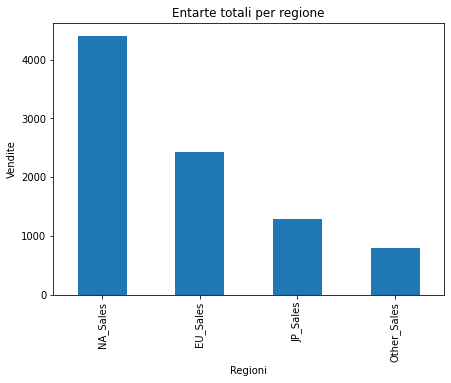

In [ ]:
venditeRegione.plot(kind='bar', x='regione', y='tot_vendite', xlabel='Regioni', ylabel='Vendite', title='Entarte totali per regione', figsize=(7,5))

Visualizziamo le percentuali in un grafico a torta

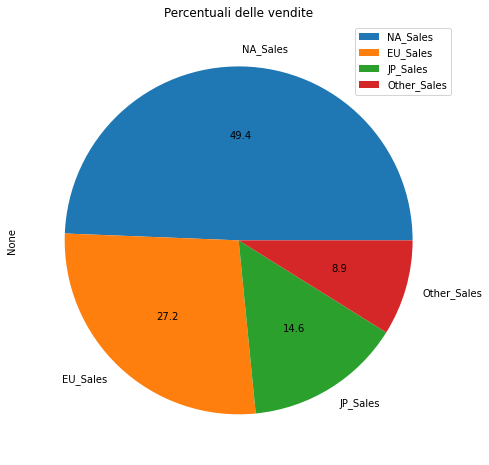

In [ ]:
venditeRegione.plot(kind='pie', autopct='%.1f',  legend=True, figsize=(8,8), title='Percentuali delle vendite')

Dai grafici otteniamo come informazione che il NA a livello di vendite ha un mercato molto florido rispetto al resto del mondo (inteso come somma di EU, JP e Other)

##Come si comportano i giochi venduti nel mondo nell'anno in cui sono usciti?
Valori compresi dal 1980 al 2020.

In questa sezione vogliamo osservare tramite metodi grafici e non i giochi su singola piattaforma e non su somma di vendite del gioco su tutte le piattaforme disponibili per il gioco.

leviamo le righe dove l'anno e' mancante

In [ ]:
video_games.dropna(subset=['Year_of_Release'], inplace=True)
video_games['Year_of_Release'].isnull().sum()

0

In [ ]:
video_games['Year_of_Release'].describe()

count    16448.000000
mean      2006.488996
std          5.877470
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2020.000000
Name: Year_of_Release, dtype: float64

Stampiamo le prime e ultime 5 righe in ordine di vendite globali

In [ ]:
gameBest_Global_Sales = video_games.sort_values(by=['Global_Sales'], ascending=False)
gameBest_Global_Sales[['Name', 'Global_Sales']]

,Name,Global_Sales
0,Wii Sports,82.53
1,Super Mario Bros.,40.24
2,Mario Kart Wii,35.52
3,Wii Sports Resort,32.77
4,Pokemon Red/Pokemon Blue,31.37
...,...,...
16295,Casper,0.01
16297,Adventure Time: The Secret of the Nameless,0.01
16298,Football Manager 2005,0.01
16299,Hakuoki: Reimeiroku DS,0.01


Osserviamo come Wii Sports e' il gioco piu' venduto con ben 82.53 milioni di copie vendute a livello globale e come si distacchi dalla seconda posizione che ha solo la meta' delle copie vendute.

oltre ai giochi possiamo ottenere altre informazioni sulla top 5 giochi piu' venduti a livello globale

In [ ]:
gameBest_Global_Sales[['Name', 'Platform', 'Year_of_Release',  'Genre', 'Publisher', 'Global_Sales', 'Developer']].head(5)

,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Developer
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.53,Nintendo
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,40.24,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.52,Nintendo
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,32.77,Nintendo
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,31.37,NaN


Ora vediamo negli altri paesi la top 5 gioci piu' venduti con le loro caratterestiche piu' interessanti

**Nord America**

In [ ]:
gameBest_NA_Sales = video_games.sort_values(by=['NA_Sales'], ascending=False)
gameBest_NA_Sales[['Name', 'Platform', 'Year_of_Release',  'Genre', 'Publisher', 'NA_Sales', 'Developer']].head(5)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,Developer
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,Nintendo
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,NaN
9,Duck Hunt,NES,1984.0,Shooter,Nintendo,26.93,NaN
5,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,Nintendo


**Europa**

In [ ]:
gameBest_EU_Sales = video_games.sort_values(by=['EU_Sales'], ascending=False)
gameBest_EU_Sales[['Name', 'Platform', 'Year_of_Release',  'Genre', 'Publisher', 'EU_Sales', 'Developer']].head(5)

,Name,Platform,Year_of_Release,Genre,Publisher,EU_Sales,Developer
0,Wii Sports,Wii,2006.0,Sports,Nintendo,28.96,Nintendo
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,12.76,Nintendo
10,Nintendogs,DS,2005.0,Simulation,Nintendo,10.95,NaN
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,10.93,Nintendo
19,Brain Age: Train Your Brain in Minutes a Day,DS,2005.0,Misc,Nintendo,9.20,Nintendo


Notiamo come EU abbia molti dei giochi piu' venduti tra il 2005 e il 2009 a differenza del NA dove il medium si e' sviluppato prima

**Giappone**

In [ ]:
gameBest_JP_Sales = video_games.sort_values(by=['JP_Sales'], ascending=False)
gameBest_JP_Sales[['Name', 'Platform', 'Year_of_Release',  'Genre', 'Publisher', 'JP_Sales', 'Developer']].head(5)

,Name,Platform,Year_of_Release,Genre,Publisher,JP_Sales,Developer
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,10.22,NaN
12,Pokemon Gold/Pokemon Silver,GB,1999.0,Role-Playing,Nintendo,7.20,NaN
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,6.81,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,6.50,Nintendo
20,Pokemon Diamond/Pokemon Pearl,DS,2006.0,Role-Playing,Nintendo,6.04,NaN


Notiamo come il Giappone abbia una classifica molto diversa dal resto 

**Other**

In [ ]:
gameBest_OT_Sales = video_games.sort_values(by=['Other_Sales'], ascending=False)
gameBest_OT_Sales[['Name', 'Platform', 'Year_of_Release',  'Genre', 'Publisher', 'Other_Sales', 'Developer']].head(5)

,Name,Platform,Year_of_Release,Genre,Publisher,Other_Sales,Developer
17,Grand Theft Auto: San Andreas,PS2,2004.0,Action,Take-Two Interactive,10.57,Rockstar North
0,Wii Sports,Wii,2006.0,Sports,Nintendo,8.45,Nintendo
48,Gran Turismo 4,PS2,2004.0,Racing,Sony Computer Entertainment,7.53,Polyphony Digital
16,Grand Theft Auto V,PS3,2013.0,Action,Take-Two Interactive,3.96,Rockstar North
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,3.29,Nintendo


Vediamo graficamente i 10 giochi piu' venduti nei vari paesi ordinati per vendite totali

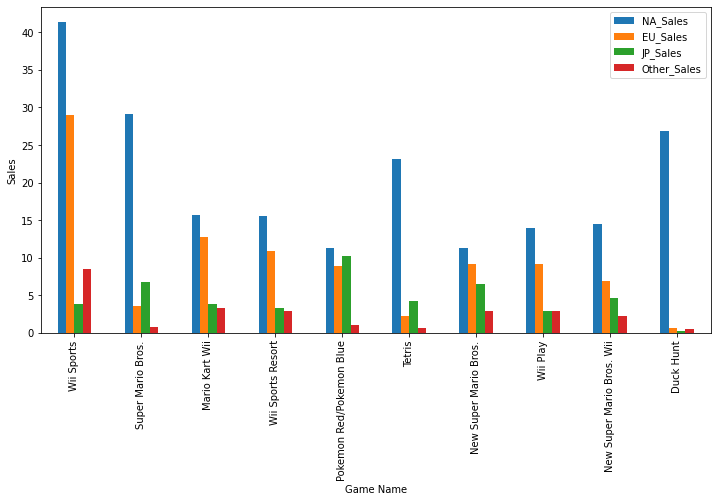

In [ ]:
gameBest_Global_Sales[['Name', 'NA_Sales','EU_Sales', 'JP_Sales', 'Other_Sales']].head(10).plot(kind='bar', x='Name', figsize=(12,6), xlabel='Game Name', ylabel='Sales')

## Come si comporta il voto della critica?

In questa parte ci vogliamo soffermare sul voto della critica osservando i suoi valori come si comportano e come sono distribuiti applicando varie tecniche per eliminare il problema del gran numero di dati mancanti.

### Eliminiamo le righe nulle

Creo una copia del dataset e ci levo i valori nulli. 

Eliminare le righe nulle in questo caso potrebbe essere la scelta migliore perche' avendo una mancanza di all'incirca il 50% dei dati, riempirle come vedremo in seguito, con una media puo' portare a una falsificazione dei dati


In [ ]:
vg_delNullCritic_Score = video_games.copy()
vg_delNullCritic_Score.dropna(subset=['Critic_Score'], inplace=True)
vg_delNullCritic_Score['Critic_Score'].describe()

count    7983.000000
mean       68.994363
std        13.920060
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: Critic_Score, dtype: float64

Come notiamo da 16717 passiamo a 7983 quindi abbiamo eliminato un 48% di righe 

In [ ]:
vg_delNullCritic_Score['Critic_Score'].isnull().sum()

0

Verifichiamo effettivamente che non ci siano piu' valori nulli

Stampiamo in ordine di Critic_Score i giochi

In [ ]:
game_bestCritic_Score = vg_delNullCritic_Score.sort_values(by=['Critic_Score'], ascending=False)
game_bestCritic_Score[['Name', 'Critic_Score', 'Platform']]

,Name,Critic_Score,Platform
51,Grand Theft Auto IV,98.0,X360
227,Tony Hawk's Pro Skater 2,98.0,PS
57,Grand Theft Auto IV,98.0,PS3
5350,SoulCalibur,98.0,DC
1877,NFL 2K1,97.0,DC
...,...,...,...
10016,Rugby 15,19.0,PS4
12132,Anubis II,19.0,Wii
15345,Balls of Fury,19.0,Wii
10663,Leisure Suit Larry: Box Office Bust,17.0,PS3


#### Distribuzione dei voti della critica

vediamo ora come sono distribuiti i voti della critica, gia' grazie alla funzione describe() vista sopra possiamo osservare varie informazioni su questa colonna 

Dividiamo in bins per avere una visualizzazzione grafica di come i voti della critica si sono distribuiti nel tempo

(76.75, 81.0]      1117
(68.25, 72.5]       928
(72.5, 76.75]       925
(59.75, 64.0]       826
(64.0, 68.25]       790
(81.0, 85.25]       736
(55.5, 59.75]       541
(85.25, 89.5]       467
(51.25, 55.5]       378
(47.0, 51.25]       314
(42.75, 47.0]       265
(89.5, 93.75]       242
(38.5, 42.75]       130
(34.25, 38.5]       114
(93.75, 98.0]        85
(30.0, 34.25]        54
(25.75, 30.0]        44
(21.5, 25.75]        15
(17.25, 21.5]        10
(12.914, 17.25]       2
Name: Critic_Score, dtype: int64


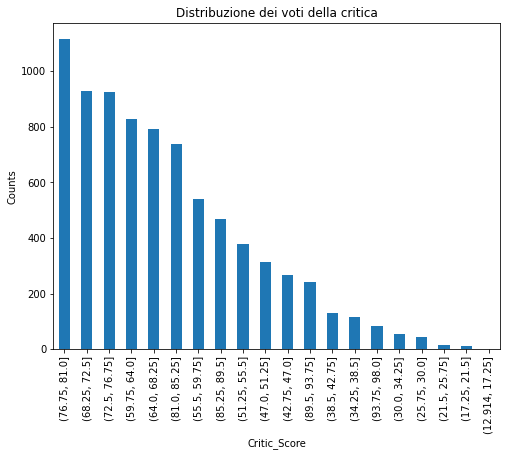

In [ ]:
cs = vg_delNullCritic_Score['Critic_Score']
cs = cs.value_counts(bins=20)
print(cs)
cs.plot(kind = 'bar', figsize=(8,6), title='Distribuzione dei voti della critica', xlabel='Critic_Score', ylabel='Counts')

Notiamo tramite il grafico e la funzione describe() una media di 68 quindi in una votazione da 0 a 100 otteniamo che in generale i giochi sono per lo piu' sopra la soglia di sufficenza.

###Riempiamo con una media dei voti

i voti della critica insieme ai voti del pubblico sono mancanti in grandi quantita fino a +-50% dei dati totali  

per questo invece di eliminare le righe con elementi nulli proviamo a completare con una media dei voti

In [ ]:
vg_Mean_CriticScore = video_games.copy()
average_Critic_Score = vg_Mean_CriticScore['Critic_Score'].mean()
print("average_Critic_Score: ", average_Critic_Score, '\n')

#fillna: riempie le entrate mancanti con la media
vg_Mean_CriticScore['Critic_Score'].fillna(average_Critic_Score, inplace = True)


average_Critic_Score:  68.99436302142053 



qui ovviamente non abbiamo una perdita di quantita' di righe ma notiamo come la media sia rimasta presoche' invariata [68.994363]

In [ ]:
vg_Mean_CriticScore['Critic_Score'].isnull().sum()

0

verifichiamo effettivamente che non ci siano piu' valori nulli

Stampiamo in ordine di Critic_Score i giochi

In [ ]:
game_bestCritic_Score = vg_Mean_CriticScore.sort_values(by=['Critic_Score'], ascending=False)
game_bestCritic_Score[['Name', 'Critic_Score', 'Platform']]

,Name,Critic_Score,Platform
51,Grand Theft Auto IV,98.0,X360
227,Tony Hawk's Pro Skater 2,98.0,PS
57,Grand Theft Auto IV,98.0,PS3
5350,SoulCalibur,98.0,DC
42,Grand Theft Auto V,97.0,PS4
...,...,...,...
12132,Anubis II,19.0,Wii
12823,Ride to Hell,19.0,X360
10016,Rugby 15,19.0,PS4
10663,Leisure Suit Larry: Box Office Bust,17.0,PS3


####Distribuzione dei voti della critica

vediamo ora come sono distribuiti i voti della critica

In [ ]:
vg_Mean_CriticScore['Critic_Score'].describe()

count    16448.000000
mean        68.994363
std          9.697362
min         13.000000
25%         68.994363
50%         68.994363
75%         70.000000
max         98.000000
Name: Critic_Score, dtype: float64

normalizziamo e dividiamo in bins per avere una visualizzazione grafica di come i voti della critica si sono distribuiti nel tempo

(68.25, 72.5]      9393
(76.75, 81.0]      1117
(72.5, 76.75]       925
(59.75, 64.0]       826
(64.0, 68.25]       790
(81.0, 85.25]       736
(55.5, 59.75]       541
(85.25, 89.5]       467
(51.25, 55.5]       378
(47.0, 51.25]       314
(42.75, 47.0]       265
(89.5, 93.75]       242
(38.5, 42.75]       130
(34.25, 38.5]       114
(93.75, 98.0]        85
(30.0, 34.25]        54
(25.75, 30.0]        44
(21.5, 25.75]        15
(17.25, 21.5]        10
(12.914, 17.25]       2
Name: Critic_Score, dtype: int64


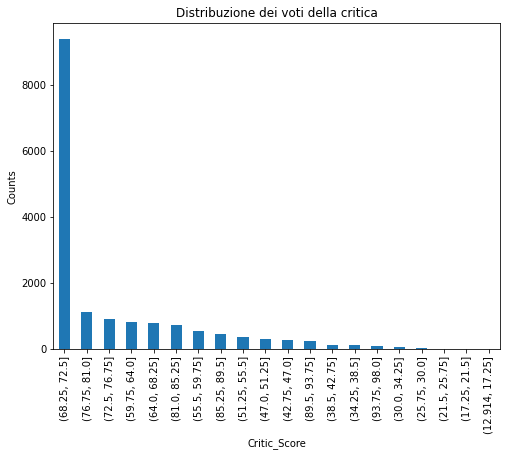

In [ ]:
cs = vg_Mean_CriticScore['Critic_Score']
cs = cs.value_counts(bins=20)
print(cs)
cs.plot(kind = 'bar', figsize=(8,6), title='Distribuzione dei voti della critica', xlabel='Critic_Score', ylabel='Counts')

Nel grafico possiamo vedere come la media abbia influenzato in maniera negativa, avendo ragruppato la maggior quantita' di valori intorno al bin dove ricade la media. 

Allo stesso modo ci possiamo aspettare un risultato similare se studiassimo il voto del pubblico 

## Correlazioni generali

I coefficienti di correlazione sono una misura quantitativa che descrive l’intensità dell’associazione (o relazione) tra due variabili

vediamo in generale se ci sono correlazioni tra i dati presenti nel nostro dataset

In [ ]:
video_games.corr(method='pearson')

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count
Year_of_Release,1.000000,-0.092388,0.003909,-0.168497,0.037701,-0.076340,0.011411,0.223407,-0.267851,0.175339
NA_Sales,-0.092388,1.000000,0.766548,0.451166,0.638484,0.941235,0.240083,0.296917,0.085549,0.248015
EU_Sales,0.003909,0.766548,1.000000,0.435902,0.722683,0.901671,0.221276,0.278990,0.055530,0.284135
JP_Sales,-0.168497,0.451166,0.435902,1.000000,0.291570,0.613316,0.153474,0.180386,0.126372,0.075727
Other_Sales,0.037701,0.638484,0.722683,0.291570,1.000000,0.748912,0.198410,0.252839,0.056935,0.239828
Global_Sales,-0.076340,0.941235,0.901671,0.613316,0.748912,1.000000,0.245318,0.304859,0.087951,0.266082
Critic_Score,0.011411,0.240083,0.221276,0.153474,0.198410,0.245318,1.000000,0.426930,0.579671,0.265531
Critic_Count,0.223407,0.296917,0.278990,0.180386,0.252839,0.304859,0.426930,1.000000,0.194691,0.365505
User_Score,-0.267851,0.085549,0.055530,0.126372,0.056935,0.087951,0.579671,0.194691,1.000000,0.026836
User_Count,0.175339,0.248015,0.284135,0.075727,0.239828,0.266082,0.265531,0.365505,0.026836,1.000000


visualizziamo tramite heatmap le correlazioni dei dati quantitativi 

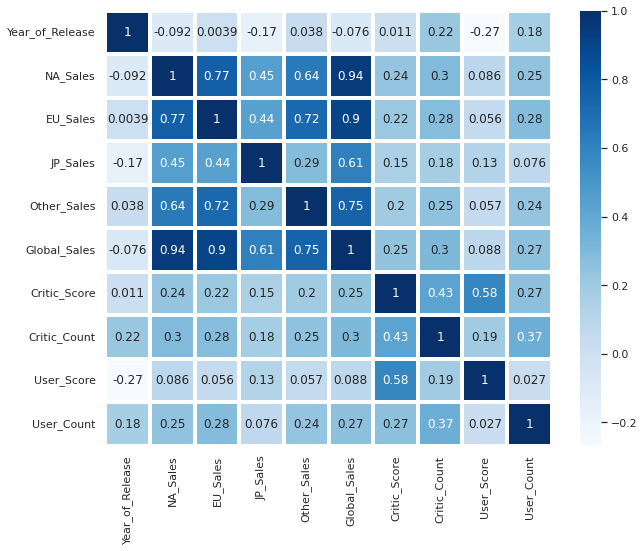

In [ ]:
sns.set(font_scale=1)
plt.figure(figsize=(10,8))
sns.heatmap(video_games.corr(), cmap = "Blues", annot=True, linewidth=3)

Grazie alla heatmap sopra creata possiamo osservare immediatamente come tutte le vendite nelle varie zone abbbiamo una correlazione tra loro 

## Correlazione tra NA_Sales e EU_Sales?

Esaminando le correlazioni generali notiamo che tra questi valori esiste una buona correlazione. 



Visualizziamo graficamente la correlazione 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


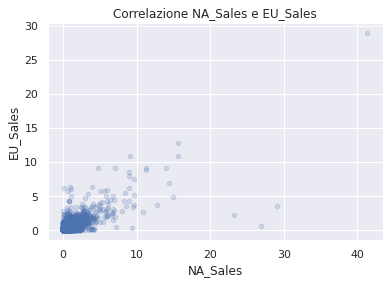

In [ ]:
video_games.plot(kind='scatter', x='NA_Sales', y='EU_Sales', alpha=0.2, title='Correlazione NA_Sales e EU_Sales')

Facciamo uno zoom nel grafico per meglo osservare la parte rilevante

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


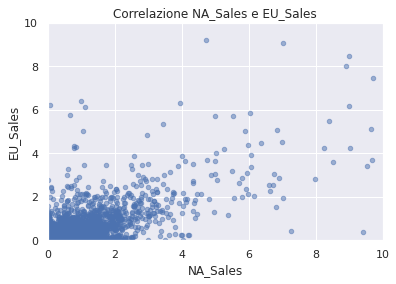

In [ ]:
video_games.plot(kind='scatter', x='NA_Sales', y='EU_Sales', alpha=0.5, xlim=(0,10), ylim=(0,10), title='Correlazione NA_Sales e EU_Sales')

Vediamo solo queste per focalizzarci su di esse

In [ ]:
video_games[['NA_Sales', 'EU_Sales']].corr(method='pearson')

,NA_Sales,EU_Sales
NA_Sales,1.000000,0.766548
EU_Sales,0.766548,1.000000


Effettivamente anche il grafico conferma il nostro valore di correlazione forte dove possiamo osservare che all'aumentare delle vendite in NA aumenta anche in EU

###T-test

Il t-test per un campione è un test statistico per determinare se un campione di dati numerici (quantitativi) differisce in modo statisticamente significativo da un altro dataset (come la popolazione o un altro campione)

Formuliamo ora un'ipotesi: 

H0 = la media delle vendite in NA e' uguale a quella in EU

HA = ci sono differenze tra le vendite medie in NA e quelle in EU.

Sappiamo che si devono verificare alcune condizioni:
1. Campione con numero di elementi n > 30;
2. Popolazione N almeno dieci volte superiore al campione N > 10*n.

Per applicare al dataset, prima di tutto verifichiamo quante vendite abbiamo nelle varie classi.

In [ ]:
NA_Sales = video_games['NA_Sales']
print('NA_Sales: ', len(NA_Sales))
print('NA_Sales mean: ', video_games['NA_Sales'].mean(), '\n') #mean() calcola la media senza tennere in conto i valori nulli

EU_Sales = video_games['EU_Sales']
print('EU_Sales: ', len(EU_Sales))
print('EU_Sales mean: ', video_games['EU_Sales'].mean(), '\n')

NA_Sales:  16448
NA_Sales mean:  0.2639646157587757 

EU_Sales:  16448
EU_Sales mean:  0.1458949416342738 



Prepariamo i dati per il t-test

In [ ]:
#mescolo le righe in maniera randomica
vg_rand = video_games.sample(frac=1).reset_index(drop=True)
campione = vg_rand['NA_Sales'].values[0:1000] #prendi valori rand

print('campione: ', campione.shape)
print('media campione: ', np.mean(campione), '\n')

campione:  (1000,)
media campione:  0.26161 



In [ ]:
popolazione_EU = video_games['EU_Sales'].values
print('num elem popolazione_EU: ',popolazione_EU.shape)
print('media campione: popolazione_EU', np.mean(popolazione_EU))

num elem popolazione_EU:  (16448,)
media campione: popolazione_EU 0.14589494163424127


per verificare le condizioni del t-test prendiamo un campione 1000.
- campione: 1000
- popolazione_EU = 16416

Quindi le due condizioni sono verificate. Eseguiamo il t-test in una riga di codice, usando la libreria scipy. Fissando un livello di confidenza del 95% il livello di significatività è 0.05.

Il livello di confidenza rappresenta la frequenza con cui la risposta ottenuta è accurata (probabilità che l’intervallo contenga il valore esatto)

In [ ]:
t_statistic, p_value = stats.ttest_1samp(a= campione, popmean= popolazione_EU.mean(), alternative='two-sided')
print(t_statistic) 
print(p_value) 
print("-> accetta ipostesi nulla") if (p_value > 0.05) else print("-> NON accetta ipostesi nulla")

5.885683500365769
5.406834944578534e-09
-> NON accetta ipostesi nulla


Il test a due code (diverso) ci dimostra che NON accetta l'ipostesi nulla e quindi possiamo dire che ci sono differenze tra i valori.

- t_statistic: la deviazione della media del campione rispetto all’ipotesi nulla
- p_value: frequenza con cui il risultato ottenuto si otterrebbe per caso




Formuliamo ora un'altra ipotesi:

HO = la media delle vendite in NA e' maggiore rispetto a quella in EU

HA = la media delle vendite in NA e' minore rispetto a quella in EU

In [ ]:
t_statistic, p_value = stats.ttest_1samp(a= campione, popmean= popolazione_EU.mean(), alternative='less')
print(t_statistic)
print(p_value)
print("-> accetta ipostesi nulla") if (p_value > 0.05) else print("-> NON accetta ipostesi nulla")

5.885683500365769
0.9999999972965825
-> accetta ipostesi nulla


Grazie ai calcoli fatti e al test a una coda accettiamo l'ipostesi nulla ottenendo che la media delle vendite in NA e' maggiore rispetto a quella in EU

Come contro prova facciamo lo stesso test precedente ma pasaando il parametro greater (maggiore) dove prima abbiamo usato less

In [ ]:
t_statistic, p_value = stats.ttest_1samp(a= campione, popmean= popolazione_EU.mean(), alternative='greater')
print(t_statistic)
print(p_value)
print("-> accetta ipostesi nulla") if (p_value > 0.05) else print("-> NON accetta ipostesi nulla")

5.885683500365769
2.703417472289267e-09
-> NON accetta ipostesi nulla


###Ora cerchiamo di implementare un modello di Regressione lineare

Utiliziamo un modello di Machine Learning: ci riferiamo ad una classe di metodi in grado di imparare da esempi invece di essere esplicitamente programmati a fare qualcosa. Il tipo e' supervisionato (con insegnante)

**Utilizziamo un modello di regressione lineare per stimare proprio le vendite in EU a partire dalle vendite in NA.**

Dividiamo il dataset a disposizione in due diversi gruppi:

- Training Set -> porzione di dati che utilizziamo per il training del nostro modello di regressione lineare;
- Validation Set -> porzione di dati che utilizziamo per valutare il nostro modello precedentemente allenato.

Non esiste un unico modo per dividere il dataset in training e test, normalmente, si utilizza un random split con una certa percentuale (per esempio 70/30 per training/test).

Usiamo la libreria scikit-learn, lo schema che usiamo e' il seguente:

1. Definire le caratteristiche da usare;
2. Definire X e y; 
3. Dividere il dataset in training e test; 
4. Istanziare un oggetto della classe LinearRegression;
5. Allenare usando la funzione fit invocata sull'oggetto istanziato (passando il training set!);
6. Visualizzare i coefficienti imparati: useremo gli attributi *intercept_=* e *coef_* sull'oggetto ottenuto come output della funzione fit.

La funzione **train_test_split(X, y)** effettua per noi lo splitting.

X_valid:  (4935, 1)
X_train:  (11513, 1)

intercept:  0.01640652279466659
coefficient:  [0.49077988]


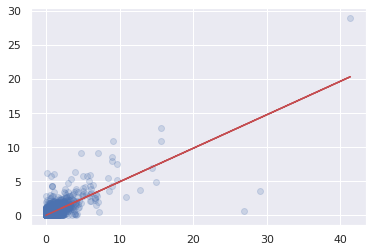

In [ ]:
#input: features
features = ['NA_Sales']
x= video_games[features]
y= video_games['EU_Sales']
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=1)       # processo randomico 
                                                # random_state=1 uso la stessa funzione randomica

#X_train,Y_train : verranno usati per addestrare il modello / funzione
#X_valid,Y_valid : verranno usati per collaudare il modello / funzione

# ----------- stampo i valori
print("X_valid: ", X_valid.shape)
print("X_train: ", X_train.shape) 

regressor = LinearRegression()  # istanzia il modello
lin_reg = regressor.fit(X_train, y_train)  # adatta il modello al nostro set di addestamento 

# ----------- stampo i valori 
print("\nintercept: ", lin_reg.intercept_)
print("coefficient: ", lin_reg.coef_)

plt.scatter(X_train, y_train, alpha=0.2)

y_hat = X_train * lin_reg.coef_ + lin_reg.intercept_
plt.plot(X_train, y_hat, color='r')

Training del modello: Il processo di identificare, tra tante soluzioni possibili, la soluzione migliore a partire dai dati a disposizione prende il nome di fase di training di un metodi di Machine Learning

Alla fine del processo di training è importante avere una misura della bontà della funzione stimata (la migliore, che abbiamo trovato con la fase di training stessa) su dati nuovi, ossia dati non utilizzati durante il training --> questo consente di verificare la stabilità/generalizzazione

Adesso possiamo usare il modello imparato, per effettuare predizioni sul validation set. E' sufficiente usare la funzione predict sull'oggetto restituito da fit, passando come argomento x_valid

[0.03112992 0.03112992 0.18327168 ... 0.01640652 0.19799508 0.01640652]


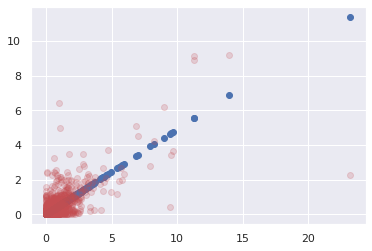

In [ ]:
y_hat = regressor.predict(X_valid) # predizioni sul nostro set di collaudo
print(y_hat)

plt.scatter(X_valid, y_hat)
plt.scatter(X_valid, y_valid, c='r', alpha=0.2)

Ora, come possiamo stimare la precisione della funzione che abbiamo imparato?

Sappiamo che non esiste una soluzione perfetta, ma possiamo trovare la soluzione migliore possibile, con i dati a disposizione. Per trovarla, useremo stime degli errori.

Visualizziamo le tre metriche per valutare i modelli a regressione di machine learning:

- lo scarto medio assoluto (MAE - Mean Absolute Error);
- l’errore quadratico medio (MSE - Mean Squared Error);
- la radice dell’errore quadratico medio (RMSE - Root of Mean Squared Error).

La metrica che viene di solito utilizzata in regressione è l’errore quadratico medio

utilizziamo le implementazioni messe a dispozione da scikit-learn

In [ ]:
y_pred = regressor.predict(X_valid)

print ('MAE:', metrics.mean_absolute_error(y_valid, y_pred))
print ('MSE:', metrics.mean_squared_error(y_valid, y_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, y_pred)))

MAE: 0.10509702471401557
MSE: 0.08959910182216907
RMSE: 0.2993310906373895


L'errore è a ivello di milioni

Come faccio a sapere se questo risultato e' un buon risultato oppure no?

Determiniamo il modello nullo.

Il modello nullo rappresenta in modo efficace il fatto di tirare a indovinare più e più volte il risultato atteso, e vedere l’efficacia del modello.

Nella regressione, possiamo sostituire tutti i valori della feature con la media sull'intero dataset.

In [ ]:
mean_EU_Sales = video_games['EU_Sales'].mean()
print("mean_EU_Sales: ", mean_EU_Sales)

null_model_y = [mean_EU_Sales] * video_games.shape[0]

print ('\nMODELLO')
print ('MAE:', metrics.mean_absolute_error(y, null_model_y))
print ('MSE:', metrics.mean_squared_error(y, null_model_y))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y, null_model_y)))

mean_EU_Sales:  0.1458949416342738

MODELLO
MAE: 0.18978440958608392
MSE: 0.2566886081261639
RMSE: 0.506644459286948


Notiamo che gli errori sono piu' grandi rispetto a quelli del modello di regressione lineare, questo ci rincuora perche vuol dire che col modello di regressione lineare abbiamo fatto un po meglio che tirare a caso.

## Vendite di giochi e voto della critica sono collegati?

In questa parte ci chiediamo se le vendite di giochi e apprezzamento della critica sono collegati, se una influenza l'altra e studiare dei modelli per stimare i valori.

Utilizziamo il dataset dove sono stati eliminati le righe nulle 

Osserviamo se riempire i dati con la media o eliminare le righe nulle ci porta ad avere una diversa correlazione tra Critic_Score e Global_Sales



In [ ]:
vg_Mean_CriticScore[['Critic_Score', 'Global_Sales']].corr()

,Critic_Score,Global_Sales
Critic_Score,1.000000,0.200819
Global_Sales,0.200819,1.000000


In [ ]:
globalS_criticS = vg_delNullCritic_Score[['Critic_Score', 'Global_Sales']]
globalS_criticS.corr(method='pearson')

,Critic_Score,Global_Sales
Critic_Score,1.000000,0.245318
Global_Sales,0.245318,1.000000


Anche a livello di correlazione vediamo che una piccola differenza la otteniamo in positivo se eliminiamo le righe nulle, rimane comunque una correlazione debole.

Come ci si puo' aspettare le due variabili sono debolmente correlate proprio per il fatto che il gioco piu' venduto quindi quello mainstream non e' per forza il gioco che per piu' aspetti (grafica, game design...) ha riscosso piu' sucesso dalla critica

Usiamo una tecnica di visualizzazione opportuna per verificare come si comporta la relazione tra Critic_Score e Global_Sales.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


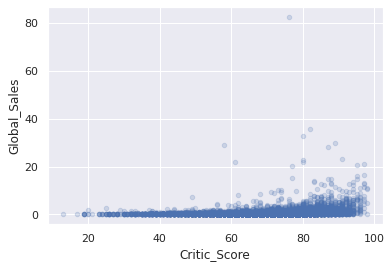

In [ ]:
globalS_criticS.plot(kind='scatter', x='Critic_Score', y='Global_Sales', alpha=0.2)

notiamo come all'aumetare del voto della critica abbiamo anche un leggero aumento delle vendite globali

####Ora cerchiamo di implementare un modello di Regressione lineare

**Utilizziamo un modello di regressione lineare per stimare proprio il Global_Sales a partire dal Critic_Score.**

dividiamo il dataset a disposizione in due diversi gruppi:

- Training Set -> porzione di dati che utilizziamo per il training del nostro modello di regressione lineare;
- Validation Set -> porzione di dati che utilizziamo per valutare il nostro modello precedentemente allenato.

Usiamo la libreria scikit-learn, lo schema che useremo e' il seguente:

1. Definire le caratteristiche da usare;
2. Definire X e y; 
3. Dividere il dataset in training e test; 
4. Istanziare un oggetto della classe LinearRegression;
5. Allenare usando la funzione fit invocata sull'oggetto istanziato (passando il training set!);
6. Visualizzare i coefficienti imparati: useremo gli attributi *intercept_=* e *coef_* sull'oggetto ottenuto come output della funzione fit.


X_valid:  (2395, 1)
X_train:  (5588, 1)

intercept:  -1.6573887453522116
coefficient:  [0.03422534]


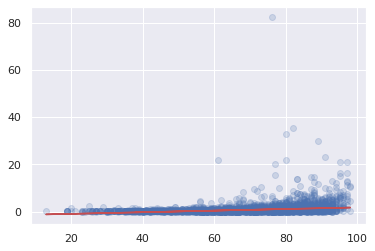

In [ ]:
#input: features
features = ['Critic_Score']
x= globalS_criticS[features]
y= globalS_criticS['Global_Sales']
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=1)       # processo randomico 
                                                # random_state=1 uso la stessa funzione randomica

#X_train,Y_train : verranno usati per addestrare il modello / funzione
#X_valid,Y_valid : verranno usati per collaudare il modello / funzione

# ----------- stampo i valori
print("X_valid: ", X_valid.shape)
print("X_train: ", X_train.shape) 

regressor = LinearRegression()  # istanzia il modello
lin_reg = regressor.fit(X_train, y_train)  # adatta il modello al nostro set di addestamento 

# ----------- stampo i valori 
print("\nintercept: ", lin_reg.intercept_)
print("coefficient: ", lin_reg.coef_)

plt.scatter(X_train, y_train, alpha=0.2)

y_hat = X_train * lin_reg.coef_ + lin_reg.intercept_
plt.plot(X_train, y_hat, color='r')

Alla fine del processo di training, è importante avere una misura della bontà della funzione stimata (la migliore, che abbiamo trovato con la fase di training stessa) su dati nuovi, ossia dati non utilizzati durante il training --> questo consente di verificare la stabilità/generalizzazione

Adesso possiamo usare il modello imparato, per effettuare predizioni sul validation set. E' sufficiente usare la funzione predict sull'oggetto restituito da fit, passando come argomento x_valid

[0.94373707 1.11486377 0.84106105 ... 0.29345562 1.04641309 0.3619063 ]


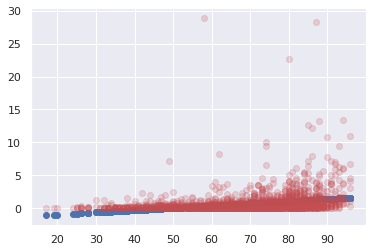

In [ ]:
y_hat = regressor.predict(X_valid) # predizioni sul nostro set di collaudo
print(y_hat)

plt.scatter(X_valid, y_hat)
plt.scatter(X_valid, y_valid, c='r', alpha=0.2)

Visualizziamo le tre metriche per valutare i modelli a regressione di machine learning:

- lo scarto medio assoluto (MAE - Mean Absolute Error);
- l’errore quadratico medio (MSE - Mean Squared Error);
- la radice dell’errore quadratico medio (RMSE - Root of Mean Squared Error).

La metrica che viene di solito utilizzata in regressione è l’errore quadratico medio

In [ ]:
# calcolate le predizioni sul validation set (y_pred)
y_pred = regressor.predict(X_valid)

print ('MAE:', metrics.mean_absolute_error(y_valid, y_pred))
print ('MSE:', metrics.mean_squared_error(y_valid, y_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y_valid, y_pred)))

MAE: 0.6919681898185115
MSE: 2.083201487578609
RMSE: 1.4433299995422422


L'errore è a ivello di milioni

Determiniamo il modello nullo.

Nella regressione, possiamo sostituire tutti i valori della feature con la media sull'intero dataset.

In [ ]:
mean_Global_Sales = globalS_criticS['Global_Sales'].mean()
print("mean_Global_Sales: ", mean_Global_Sales)

null_model_y = [mean_Global_Sales] * globalS_criticS.shape[0]

print ('\nMODELLO')
print ('MAE:', metrics.mean_absolute_error(y, null_model_y))
print ('MSE:', metrics.mean_squared_error(y, null_model_y))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(y, null_model_y)))

mean_Global_Sales:  0.6934611048478229

MODELLO
MAE: 0.7295016481613167
MSE: 3.353220301850565
RMSE: 1.8311800298852554


notiamo che gli errori sono piu' grandi rispetto a quelli della feature Critic_Score del modello di regressione lineare, questo ci rincuora perche vuol dire che col modello di regressione lineare abbiamo fatto un po meglio che tirare a caso

##Vendite di giochi e voto del pubblico sono collegati?

Dato che il pubblico sono anche le persone che effettivamente comprano il titolo andiamo a verifcare se questi dati sono +- correlati rispetto al numero di copie vendute

Anche qui mancano moltissimi User_Score quindi eliminiamo le righe nulle dove grazie al confronto precedente abbiamo appurato, secondo la nostra tesi, che per un così grande numero di righe nulle sia meglio eliminare piuttosto che sostituire con una media


In [ ]:
vg_delNullUser_Score = video_games.copy()
vg_delNullUser_Score.dropna(subset=['User_Score'], inplace=True)
vg_delNullUser_Score.shape[0]

7463

N.B = ogni volta mi faccio una copia del dataset e ci levo le righe proprio per il fatto che andando a eliminare valori all'interno di colonne nulle  protrei privarmi di dati che sono contenuti in un'altra colonna

Qui notiamo infatti che se eliminassimo entrambe quando effetivamente non ci servono perderemmo ulteriormente e inutilmente delle righe 

In [ ]:
vg_delNullUserCritic_Score = vg_delNullUser_Score.copy()
vg_delNullUserCritic_Score.dropna(subset=['Critic_Score'], inplace=True)
vg_delNullUserCritic_Score.shape[0]

6894

verifichiamo che effettivamente non abbiamo piu' valori nulli 

In [ ]:
vg_delNullUser_Score['User_Score'].isnull().sum()

0

In [ ]:
vg_delNullUser_Score['User_Score'].describe()

count    7463.000000
mean       71.263299
std        14.994467
min         0.000000
25%        64.000000
50%        75.000000
75%        82.000000
max        97.000000
Name: User_Score, dtype: float64

In [ ]:
globalS_userS = vg_delNullUser_Score[['Global_Sales', 'User_Score']]
globalS_userS.corr(method='pearson')

,Global_Sales,User_Score
Global_Sales,1.000000,0.087951
User_Score,0.087951,1.000000


Qui notiamo proprio che i due valori sono meno correlati rispettio al precedente voto della critica

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


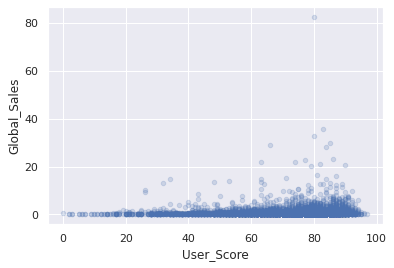

In [ ]:
globalS_userS.plot(kind='scatter', x='User_Score', y='Global_Sales', alpha=0.2)

Anche qui potremmo implemntiamo un modello di Regressione lineare ma avendo una correlazione sotto la soglia debole non lo faremo

##Come si comportano i giochi prodotti e venduti per anno?

in questa parta vogliamo vedere come la vendita annua di videogiochi si distribuisce 

verifichiamo che non ci siano valori mancanti

In [ ]:
video_games['Year_of_Release'].isnull().sum()

0

In [ ]:
video_games['Year_of_Release'].describe()

count    16448.000000
mean      2006.488996
std          5.877470
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2020.000000
Name: Year_of_Release, dtype: float64

Visualizziamo quali e quanti valori unici abbiamo

In [ ]:
year_unique = video_games.sort_values(by=['Year_of_Release'])
year_unique = year_unique['Year_of_Release'].unique()
year_unique

array([1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988.,
       1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
       2016., 2017., 2020.])

In [ ]:
year_unique.size

39

grazie a questa visualizzazione osserviamo velocemente che gli anni 2018 e 2019 non sono presenti 

vediamo le vendite annue complessive per paese:

questa rapressentazione e' sicuramente precisa ma non ci fa comprendere velocemnete come le vendite annue di vidiogiochi si sono distribuite nell'unita' di tempo da noi presa in considerazione

utilizzando la funzione groupby() ragruppiamo per anno e facciamo la somma delle vendite per ogni anno 

In [ ]:
yearGroup = video_games [['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]
yearGroup = yearGroup.groupby('Year_of_Release').sum()
yearGroup

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Year_of_Release,,,,,
1980.0,10.59,0.67,0.00,0.12,11.38
1981.0,33.40,1.96,0.00,0.32,35.77
1982.0,26.92,1.65,0.00,0.31,28.86
1983.0,7.76,0.80,8.10,0.14,16.79
1984.0,33.28,2.10,14.27,0.70,50.36
1985.0,33.73,4.74,14.56,0.92,53.94
1986.0,12.50,2.84,19.81,1.93,37.07
1987.0,8.46,1.41,11.63,0.20,21.74
1988.0,23.87,6.59,15.76,0.99,47.22


visualizziamo una media e la std globale e specifica per le varie zone delle vendite

In [ ]:
print('Global_Sales: mean: ', yearGroup['Global_Sales'].mean())
print('std: ', yearGroup['Global_Sales'].std(), '\n')

print('NA_Sales: mean: ', yearGroup['NA_Sales'].mean())
print('std: ', yearGroup['NA_Sales'].std(), '\n')

print('EU_Sales: mean: ', yearGroup['EU_Sales'].mean())
print('std: ', yearGroup['EU_Sales'].std(), '\n')

print('JP_Sales: mean: ', yearGroup['JP_Sales'].mean())
print('std: ', yearGroup['JP_Sales'].std(), '\n')

print('Other_Sales: mean: ', yearGroup['Other_Sales'].mean())
print('std: ', yearGroup['Other_Sales'].std(), '\n')

Global_Sales: mean:  226.12615384615384
std:  209.0783055978308 

NA_Sales: mean:  111.32538461538464
std:  106.64216044042249 

EU_Sales: mean:  61.53025641025639
std:  62.2451823748625 

JP_Sales: mean:  33.09487179487179
std:  21.115878643906424 

Other_Sales: mean:  20.06794871794872
std:  24.553317621206045 



notiamo come le vendite in NA siano molto superiori a tutto il resto e grazie alla std osserviamo come i valori ragruppati per anno abbiano valori poco ragruppati intorno alla media quindi una forte variabilita' 

vediamo anche quanti elementi abbiamo per gruppo

questo valore ci dice anche quanti giochi sono usciti in un determinato anno 

In [ ]:
yearGroupCont = video_games.groupby(['Year_of_Release']).size().reset_index(name='counts')
yearGroupCont

,Year_of_Release,counts
0,1980.0,9
1,1981.0,46
2,1982.0,36
3,1983.0,17
4,1984.0,14
5,1985.0,14
6,1986.0,21
7,1987.0,16
8,1988.0,15
9,1989.0,17


Vediamo una media nei 40 anni di giochi usciti per anno 

In [ ]:
print('yearGroupCont media: ', yearGroupCont['counts'].mean())
print('yearGroupCont std: ', yearGroupCont['counts'].std())

yearGroupCont media:  421.7435897435897
yearGroupCont std:  450.54036082702186


Media: quindi mediamente nel mondo escono 422 all'anno  

std: la std ci conferma quello che osserviamo la media e' si 422 ma la std e' 451 proprio per il fatto che abbiamo anni con un gioco e anni con +1000 giochi, questo valore ci dice anche che abbiamo una forte varabilita

Questo grafico ci permette di osservare la produzione di videogiochi per anno, quindi quanti titoti sono usciti

P.S i dati a partire dal 2017 e' probabile che abbiano delle grevi mancanze come si puo' motare dai dati sopra riportati 

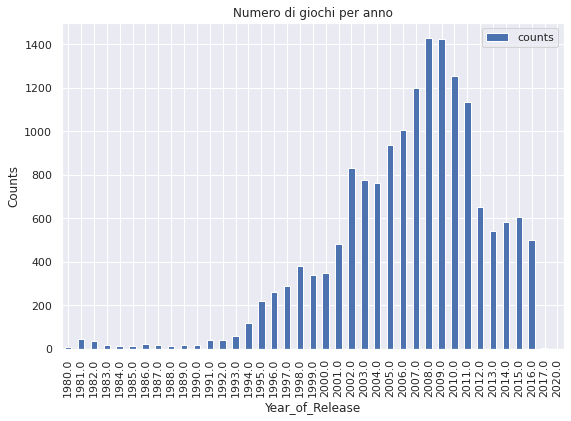

In [ ]:
yearGroupCont.plot(kind='bar', x='Year_of_Release', y='counts', figsize=(9,6), xlabel='Year_of_Release', ylabel='Counts', title='Numero di giochi per anno')

Vediamo ora tramite grafici le vendite nel mondo e nei vari paesi

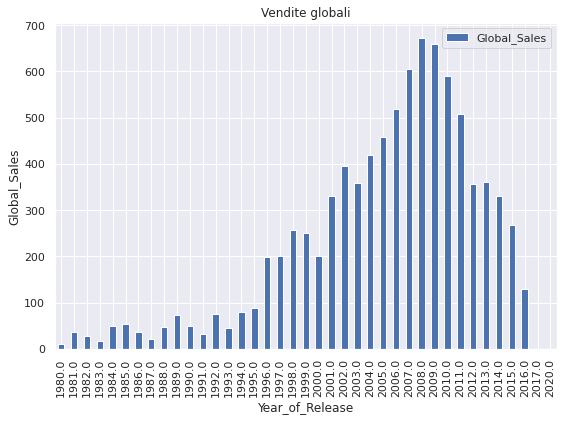

In [ ]:
yearGroup.plot(kind='bar', y='Global_Sales', figsize=(9,6), ylabel='Global_Sales', title='Vendite globali')

Con il grafico globale possiamo osservare come dal 1995 fino al 2008 ci sia stata un crescita quasi costante.

probabile cause della crescita:
Nascita del WEB 1996: Sono connessi ad Internet 10 milioni di computer.

probabilmente la drastica discesa e' dovuta a molteplici fattori tra cui 
- i prezzi dei singoli videogiochi si sono alzati progressivamente
- Crisi finanziaria del 2007-2008



Ora andiamo a osservare nei singoli paesi/stati come sono andate le vendite:

**Nord America**

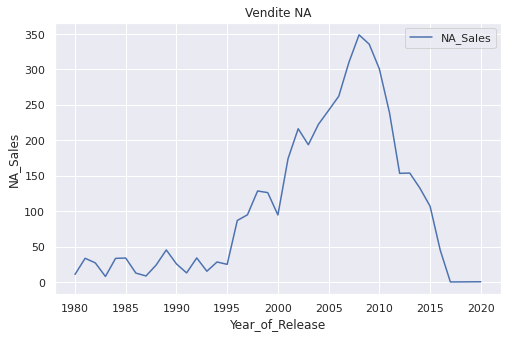

In [ ]:
yearGroup.plot(kind='line', y='NA_Sales', figsize=(8,5), ylabel='NA_Sales', title='Vendite NA')

**Europa**

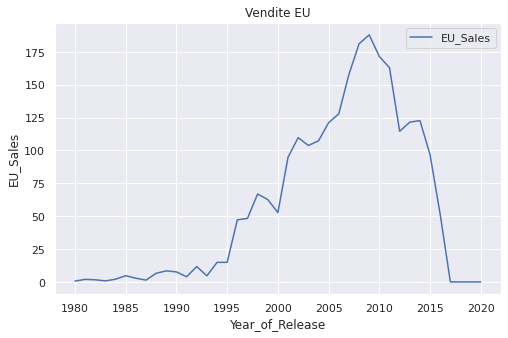

In [ ]:
yearGroup.plot(kind='line', y='EU_Sales', figsize=(8,5), ylabel='EU_Sales', title='Vendite EU')

**Giappone**

il giappone e' sempre stato un grande produttore di videogiochi, infatti rispetto a tutti gli altri le vendite incremnetano prima e anche la decrescita incomincia dopo 

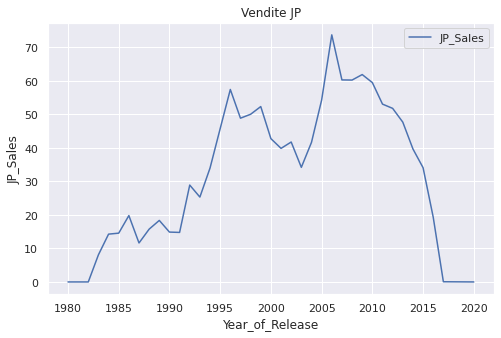

In [ ]:
yearGroup.plot(kind='line', y='JP_Sales', figsize=(8,5), ylabel='JP_Sales', title='Vendite JP')

**Altri paesi**

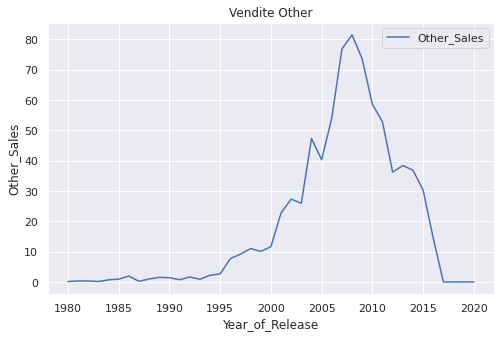

In [ ]:
yearGroup.plot(kind='line', y='Other_Sales', figsize=(8,5), ylabel='Other_Sales', title='Vendite Other')

vediamo ora le varie vendite assime 

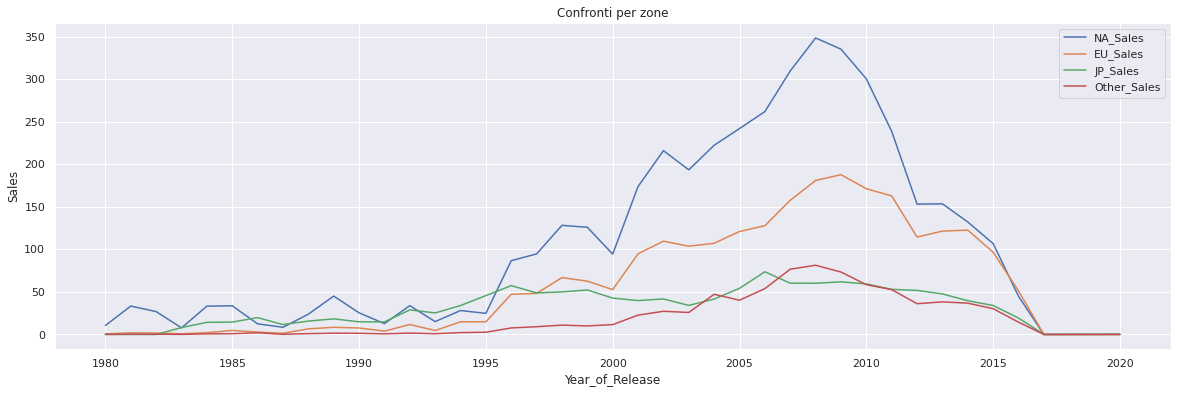

In [ ]:
yearGroup[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].plot(kind='line', figsize=(20,6), ylabel='Sales', title='Confronti per zone')

ovviamente il giappone anche se e' un grande produttore con molteplici sedi importanti (Nintendo, Sony Interactive Entertainment, From Software... ) avendo una popolazione esigua   (EU: 447,7 milioni di abitanti, JP: 125,8 milioni) rispetto all'europa il numero di vendite e' certamente piu' basso sul territorio 

##Come si comportano i generi di videogiochi e le vendite?

In questa parte vogliamo osservare come i generi di videogiochi si comportano in relazione alle vendite in tutto l'arco di tempo che abbiamo a disponibile nel dataset

vediamo se abbiamo dati nulli sui generi 

In [ ]:
video_games['Genre'].isnull().sum()

0

In [ ]:
video_games['Genre'].describe()

count      16448
unique        12
top       Action
freq        3308
Name: Genre, dtype: object

esaminiamo quanti giochi abbiamo di un determinato genere

In [ ]:
genreCounts = video_games['Genre'].value_counts()
genreCounts

Action          3308
Sports          2306
Misc            1721
Role-Playing    1483
Shooter         1296
Adventure       1293
Racing          1226
Platform         878
Simulation       858
Fighting         837
Strategy         673
Puzzle           569
Name: Genre, dtype: int64

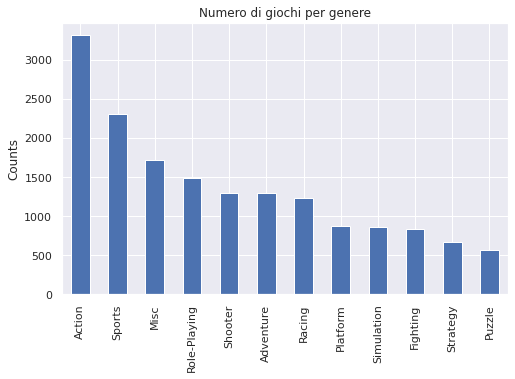

In [ ]:
genreCounts.plot(kind='bar', ylabel='Counts', figsize=(8,5), title='Numero di giochi per genere' )

Ragruppiamo per genere

In [ ]:
genreGroup = video_games.groupby('Genre')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']].sum()
genreGroup

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Genre,,,,,
Action,863.17,510.99,160.15,182.22,1717.63
Adventure,101.52,63.20,52.24,16.37,233.46
Fighting,220.51,99.00,87.28,35.87,442.63
Misc,399.57,210.60,107.02,73.10,790.94
Platform,444.44,199.39,130.71,51.01,825.86
Puzzle,121.13,49.78,56.68,12.30,240.33
Racing,356.86,234.49,56.63,75.51,723.70
Role-Playing,330.04,188.24,353.44,59.41,930.90
Shooter,584.83,314.52,38.68,103.33,1041.83


Visualizziamo graficamente un grafico a torta per meglio osservare come sono distribuite le vendite totali ragruppate per genere

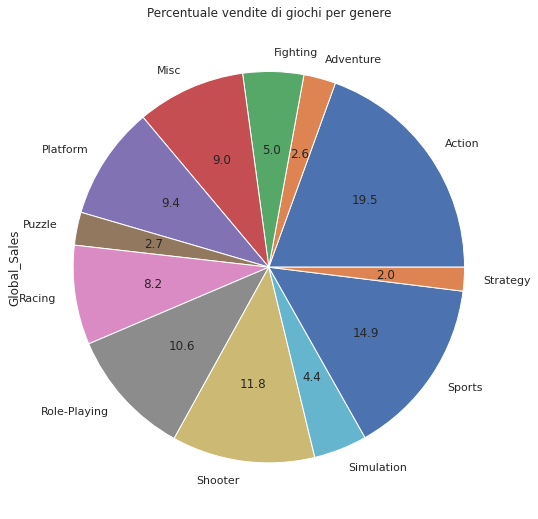

In [ ]:
genreGroup.plot(kind='pie', y='Global_Sales', legend=False, autopct='%.1f', figsize=(10, 9), title='Percentuale vendite di giochi per genere')

Vediamo tramite una rapresentazione grafica i generi ordinati per vendite

**Global_Sales**

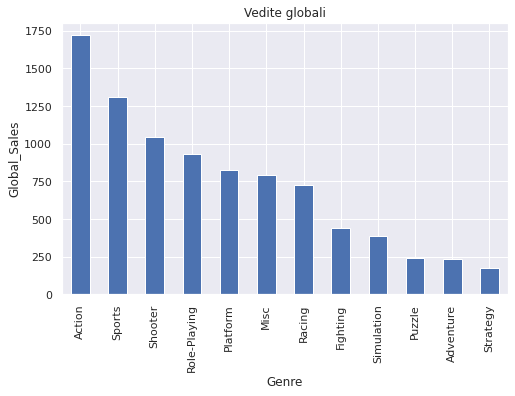

In [ ]:
temp = genreGroup.sort_values(by=['Global_Sales'], ascending=False)
temp['Global_Sales'].plot(kind='bar', ylabel='Global_Sales', figsize=(8,5), title='Vedite globali')

**NA_Sales**

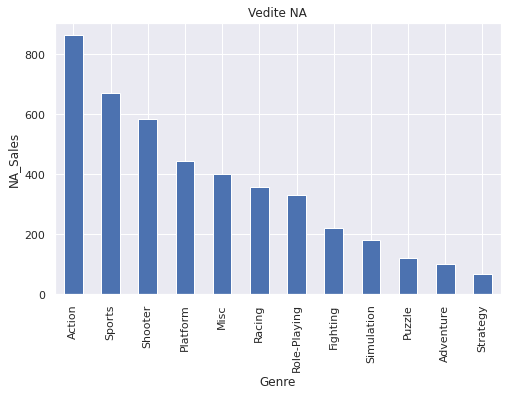

In [ ]:
temp = genreGroup.sort_values(by=['NA_Sales'], ascending=False)
temp['NA_Sales'].plot(kind='bar', ylabel='NA_Sales', figsize=(8,5), title='Vedite NA')

**EU_Sales**

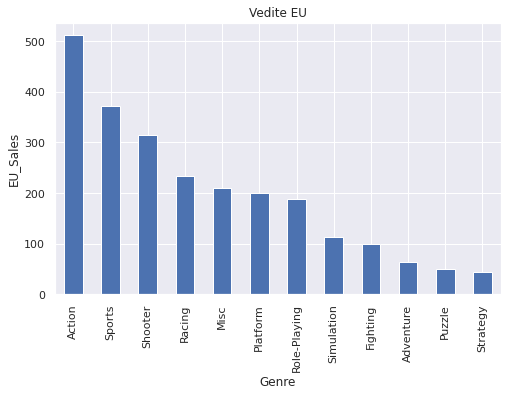

In [ ]:
temp = genreGroup.sort_values(by=['EU_Sales'], ascending=False)
temp['EU_Sales'].plot(kind='bar', ylabel='EU_Sales', figsize=(8,5), title='Vedite EU')

**JP_Sales**

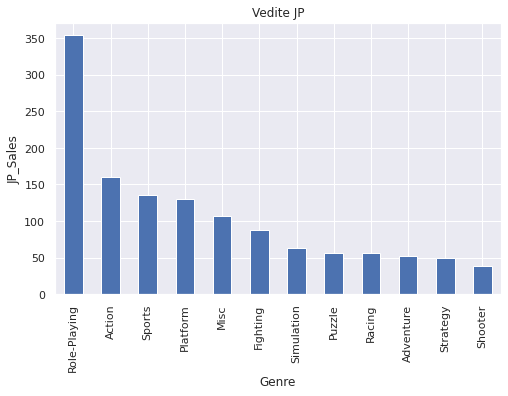

In [ ]:
temp = genreGroup.sort_values(by=['JP_Sales'], ascending=False)
temp['JP_Sales'].plot(kind='bar', ylabel='JP_Sales', figsize=(8,5), title='Vedite JP')

*inciso storico*

Esaminando il dataset notiamo come il Giappone si distingue molto dal resto del mondo proprio per il fatto che ha una cultura (videoludica e non) estremamente personale e non viene facilmente influenzata dall'esterno ma anzi cerca di imporsi sul mercato globale. Dopo la seconda guerra mondiale dove si e' scontrato militarmente contro gli Stati Uniti (e ha perso) il Giappone ha sempre cercato di trovare nel mercato mondiale un proprio posto, basti pensare a quanto sono diffusi anime e manga, Italia compresa.

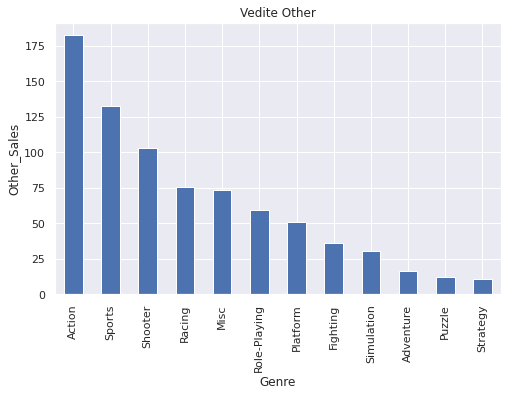

In [ ]:
temp = genreGroup.sort_values(by=['Other_Sales'], ascending=False)
temp['Other_Sales'].plot(kind='bar', ylabel='Other_Sales', figsize=(8,5), title='Vedite Other')

Mettiamo ora tutte le vendite delle varie zone assime per meglo confrontarle ordinandole per le vendite globali così da avere mediamente un grafico decrescente 

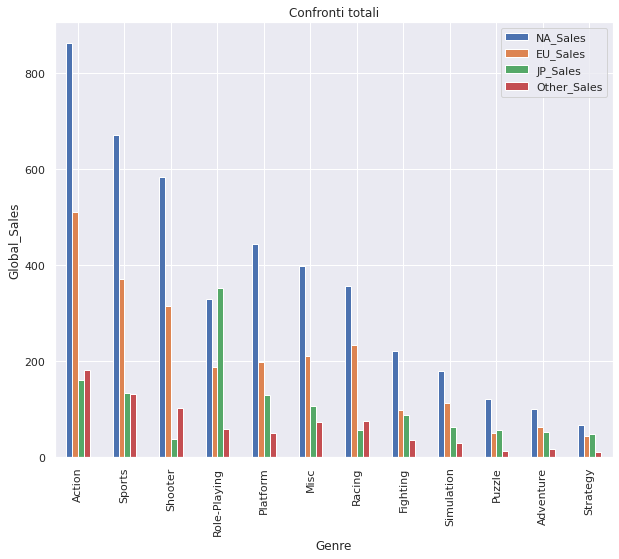

In [ ]:
temp = genreGroup.sort_values(by=['Global_Sales'], ascending=False )
temp[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].plot(kind='bar', ylabel='Global_Sales', title='Confronti totali', figsize=(10,8))

Notiamo che il genere piu' venduto non e' uguale al genere del gioco piu' venduto perche' qui facciamo una somma tra le vendite di tutti i giochi di quel genere, invece nel prendere il gioco piu' venduto guardavamo il valore singolo delle vendite di quel gioco. Sport rimane comunque in seconda posizione.

## Come si comportano i generi di videogiochi e i voti?
Soffermiamoci nuovemnete sul genere ma sta volta osserviamo il comportamneto dei voti e del numero di voti sia della critica che del pubblico 

Controlliamo che non ci siano dati mancanti tra quelli che ci servono 

In [ ]:
vg_delNullUserCritic_Score[['Genre', 'Critic_Score', 'User_Score', 'Critic_Count', 'User_Count']].isnull().sum()

Genre           0
Critic_Score    0
User_Score      0
Critic_Count    0
User_Count      0
dtype: int64

In [ ]:
vg_delNullUserCritic_Score['Genre'].unique()

array(['Sports', 'Racing', 'Platform', 'Misc', 'Action', 'Puzzle',
       'Shooter', 'Fighting', 'Simulation', 'Role-Playing', 'Adventure',
       'Strategy'], dtype=object)

Usiamo il dataset preparato in precedenza senza voto della critica e del pubblico nulli

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


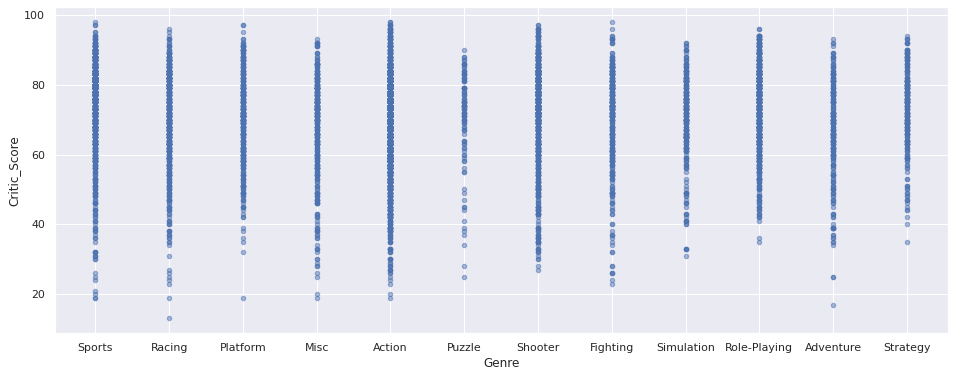

In [ ]:
vg_delNullUserCritic_Score.plot(kind='scatter', x='Genre', y='Critic_Score', figsize=(16,6), alpha=0.5)

In [ ]:
genreGroup = vg_delNullUserCritic_Score.groupby('Genre')[['Critic_Score', 'User_Score', 'Critic_Count', 'User_Count']]

Osseviamo la media e la std dei dati presi in esame

In [ ]:
genreGroup.mean()

,Critic_Score,User_Score,Critic_Count,User_Count
Genre,,,,
Action,67.836983,70.994526,30.137470,202.724453
Adventure,66.484848,71.905303,24.579545,115.068182
Fighting,69.693931,73.021108,28.881266,66.488127
Misc,67.414508,68.404145,24.766839,33.352332
Platform,70.000000,73.771712,26.784119,114.590571
Puzzle,70.694915,72.508475,28.576271,34.457627
Racing,69.621160,71.107509,25.773038,73.313993
Role-Playing,72.823776,76.209790,32.990210,330.618182
Shooter,70.968894,70.892857,37.057604,391.426267


In [ ]:
genreGroupStd = genreGroup.std()
genreGroupStd

,Critic_Score,User_Score,Critic_Count,User_Count
Genre,,,,
Action,14.264101,13.936534,20.395167,562.396869
Adventure,14.228705,16.171212,19.259320,337.725521
Fighting,14.301413,14.102781,17.287459,136.790446
Misc,14.801516,15.347825,17.493377,48.267116
Platform,13.027716,14.387754,19.915757,340.667305
Puzzle,13.573169,13.346625,17.607985,71.081107
Racing,14.111273,14.592483,18.714628,164.017209
Role-Playing,11.984572,10.828853,18.850322,983.042561
Shooter,14.372301,14.786174,21.401180,957.691296


Visualizziamo graficamente 

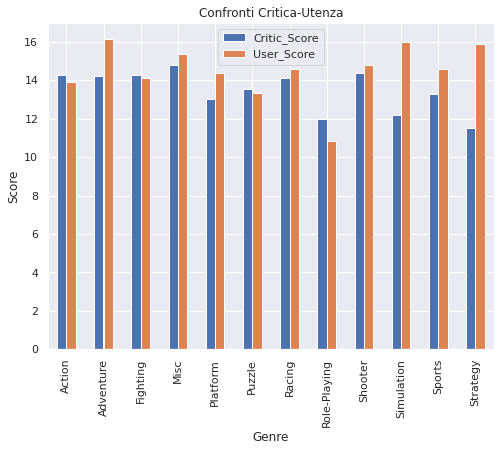

In [ ]:
genreGroupStd[['Critic_Score', 'User_Score']].plot(kind='bar',ylabel='Score', title='Confronti Critica-Utenza', figsize=(8,6))

Grazie al grafico possiamo osservare come i valori che si riferiscono al voto degli utenti abbiano un valore maggiore rispetto al voto della critica, questo ci fa osservare che generalmente i critici danno voti piu' simili tra loro.

Questo e' un dato che ci torna proprio per il fatto che la critica analizza il prodotto videoludico seguendo schemi standard al contrario dell'utenza che vota generalmente in base alle proprie preferenze soggettive piuttosto che oggettive.

Visualizziamo ora quanti voti abbiamo sia dalla parte dell'utenza che dalla critica

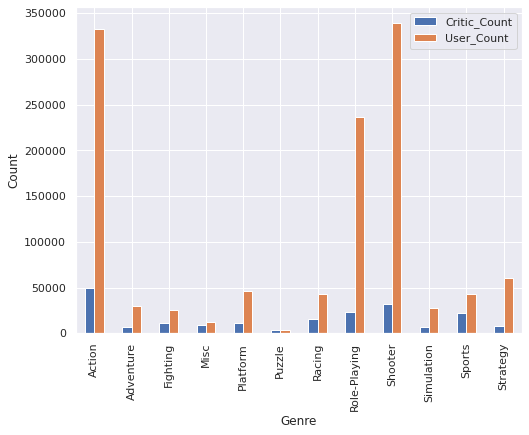

In [ ]:
genreGroup.sum()[['Critic_Count', 'User_Count']].plot(kind='bar', ylabel='Count', figsize=(8,6))

Grazie al grafico osserviamo che abbiamo in generale molti più voti da parte del pubblico piuttosto che dalla critica questi sono dati che ci tornano perche nel mondo chiunque può lasciare un voto come pubblico ma da critico non tutti possono.

Notiamo anche che Action, Role-Playing e Shooter sono molto più votati rispetto agli altri, essi sono anche tra i genrei piu' venduti.

##Come si comportano le piattaforme e le vendite?

In questa parte volgiamo studiare grazie ai dati a nostra disposizione come le vendite sono disposte nelle varie piattaforme presenti

controlliamo di non avre dati nulli 

In [ ]:
video_games['Platform'].isnull().sum()

0

vediamo quante piattaforme abbiamo e quali

In [ ]:
video_games['Platform'].describe()

count     16448
unique       31
top         PS2
freq       2127
Name: Platform, dtype: object

Vediamo quali piattaforme abbiamo

In [ ]:
name_plt = video_games['Platform'].unique()
name_plt

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

vediamo quante piattaforme abbiamo 

In [ ]:
platformGroup = video_games.groupby('Platform')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']].sum()
platformGroup

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Platform,,,,,
2600,80.78,4.86,0.00,0.84,86.57
3DO,0.00,0.00,0.10,0.00,0.10
3DS,82.65,61.27,100.62,13.27,257.92
DC,5.43,1.69,8.56,0.27,15.97
DS,380.58,188.41,175.02,59.06,803.73
GB,113.64,47.51,85.12,8.16,254.42
GBA,184.12,74.59,46.56,7.61,313.56
GC,131.94,38.32,21.34,5.13,197.14
GEN,19.27,5.52,2.67,0.89,28.36


**vendite globali per console**

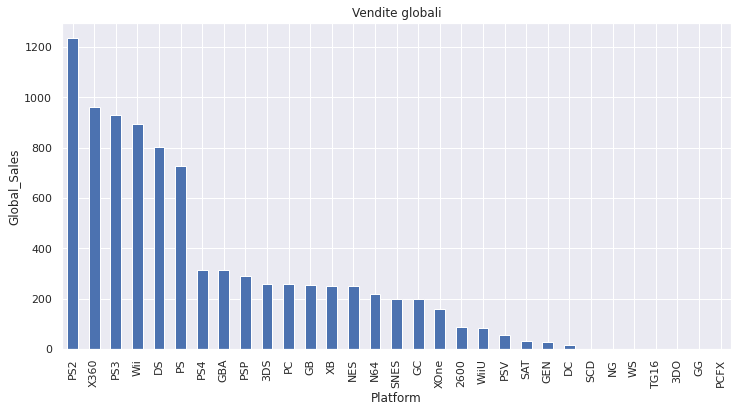

In [ ]:
tempPlot = platformGroup.sort_values(by=['Global_Sales'], ascending=False)
tempPlot['Global_Sales'].plot(kind='bar', ylabel='Global_Sales', figsize=(12, 6), title='Vendite globali')

**NA_Sales**

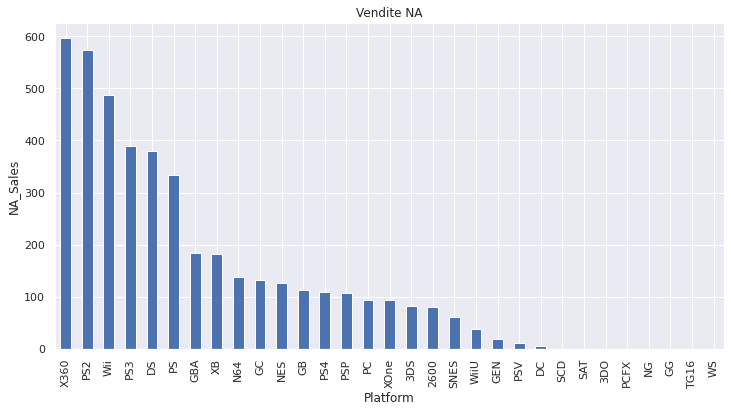

In [ ]:
tempPlot = platformGroup.sort_values(by=['NA_Sales'], ascending=False)
tempPlot['NA_Sales'].plot(kind='bar', ylabel='NA_Sales', figsize=(12, 6), title='Vendite NA')

**EU_Sales**

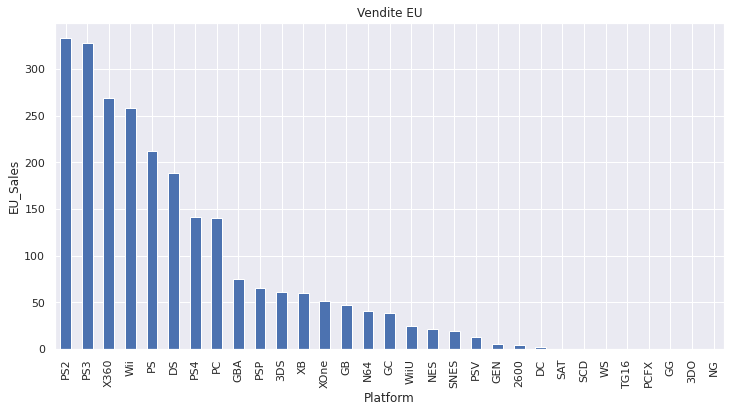

In [ ]:
tempPlot = platformGroup.sort_values(by=['EU_Sales'], ascending=False)
tempPlot['EU_Sales'].plot(kind='bar', ylabel='EU_Sales', figsize=(12, 6), title='Vendite EU')

Comparando i grafici di NA e EU notiamo come la console di casa Microsoft abbia riscontrato un leggero successo in piu' rispetto alla sua principale concorrente (Sony) a parita' di pubblico in NA.

Per quanto riguarda EU vediamo proprio come la casa Sony faccia da padrone occupando le prime due posizioni e distaccandosi in maniera considerevole dalla serie Xbox

**JP_Sales**

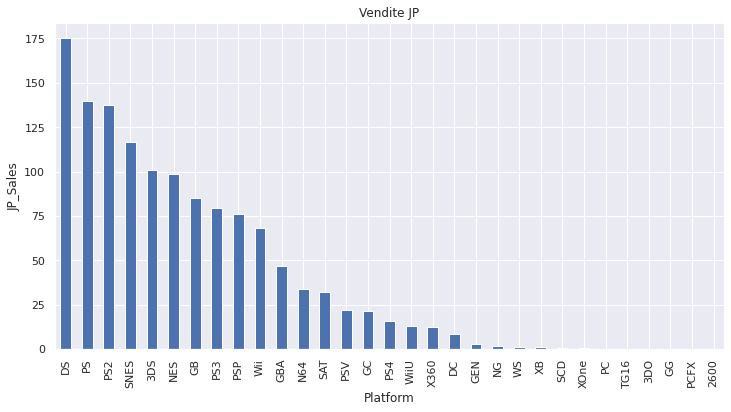

In [ ]:
tempPlot = platformGroup.sort_values(by=['JP_Sales'], ascending=False)
tempPlot['JP_Sales'].plot(kind='bar', ylabel='JP_Sales', figsize=(12, 6), title='Vendite JP')

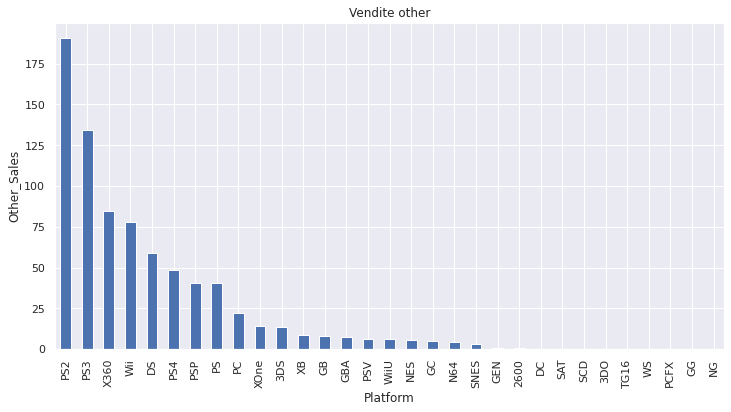

In [ ]:
tempPlot = platformGroup.sort_values(by=['Other_Sales'], ascending=False)
tempPlot['Other_Sales'].plot(kind='bar', ylabel='Other_Sales', figsize=(12, 6), title='Vendite other')

Notiamo come in Giappone la situazione sia molto diversa come gia' discusso in precedenza

**Confronti totali** 
ora mettiamo tutto su un unico grafico per meglio visualizzare i dati e li ordiniamo per vendite globali cosi da avere una descrescita media sulle piattaforme

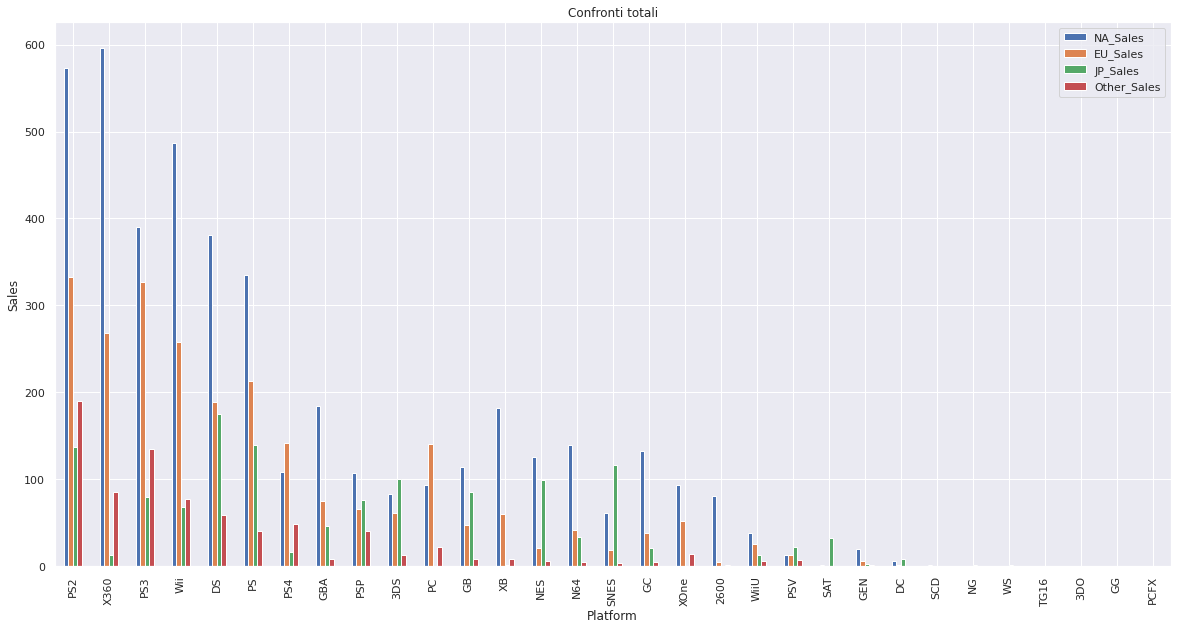

In [ ]:
tempPlot = platformGroup.sort_values(by=['Global_Sales'], ascending=False )
tempPlot[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']].plot(kind='bar', ylabel='Sales', title='Confronti totali', figsize=(20,10))

##Come si comportano i publishere e le vendite?
In questa parte vogliamo osservare come i Publishere si comportano in relazione alle vendite in tutto l'arco di tempo che abbiamo a disponibile nel dataset

Leviamo le colonne nulle 

In [ ]:
vgPublisher = video_games.copy()
vgPublisher.dropna(subset=['Publisher'], inplace=True)
vgPublisher['Publisher'].isnull().sum()

0

verifichiamo quante righe abbiamo 

In [ ]:
vgPublisher['Publisher'].describe()

count               16416
unique                579
top       Electronic Arts
freq                 1344
Name: Publisher, dtype: object

qui notiamo che abbiamo 579 valori unici di Publisher

Visualizziamo le maggiori frequenze dei 20 Publisher presenti nel dataset

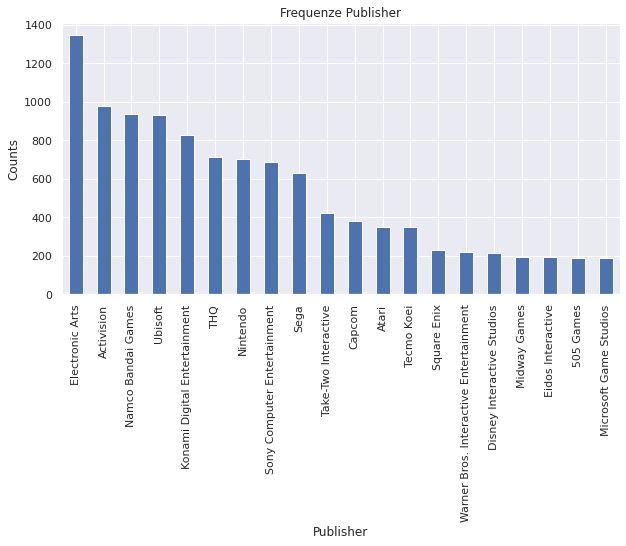

In [ ]:
vgPublisher['Publisher'].value_counts().head(20).plot(kind='bar', ylabel='Counts', xlabel='Publisher' , title='Frequenze Publisher', figsize=(10, 5))

Dato che abbiamo molti valori scegliamo di fare la top 20 dei Publisher per le vendite

In [ ]:
publisherGroup = vgPublisher.groupby('Publisher')[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']].sum()

visualizziamo globalmente i 20 Publisher per vendite globali 

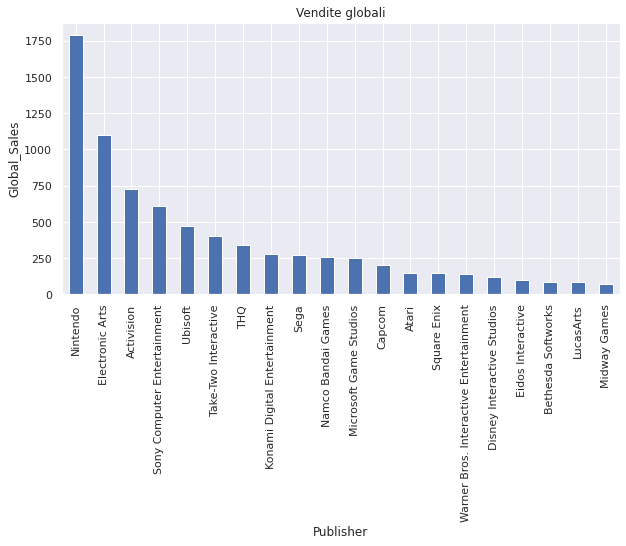

In [ ]:
tempPlot = publisherGroup.sort_values(by=['Global_Sales'], ascending=False).head(20)
tempPlot['Global_Sales'].plot(kind='bar', ylabel='Global_Sales', figsize=(10, 5), title='Vendite globali')

**NA_Sales**

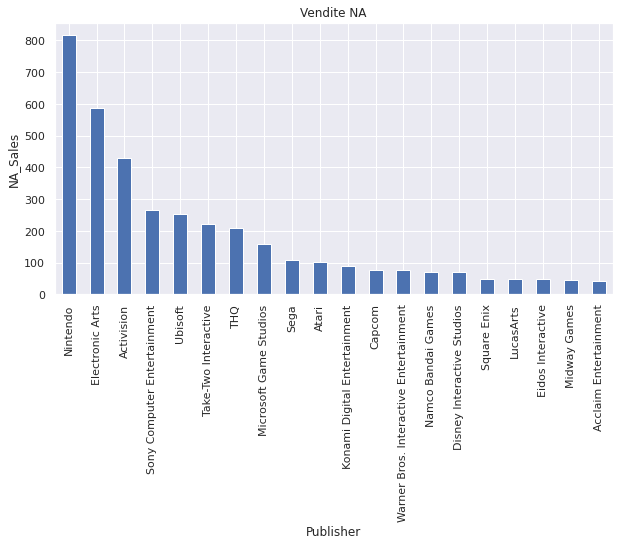

In [ ]:
tempPlot = publisherGroup.sort_values(by=['NA_Sales'], ascending=False).head(20)
tempPlot['NA_Sales'].plot(kind='bar', ylabel='NA_Sales', figsize=(10, 5), title='Vendite NA')

**EU_Sales**

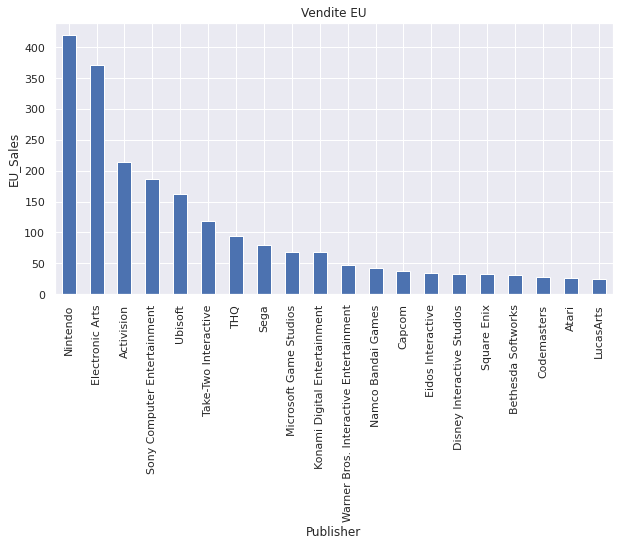

In [ ]:
tempPlot = publisherGroup.sort_values(by=['EU_Sales'], ascending=False).head(20)
tempPlot['EU_Sales'].plot(kind='bar', ylabel='EU_Sales', figsize=(10, 5), title='Vendite EU')

**JP_Sales**

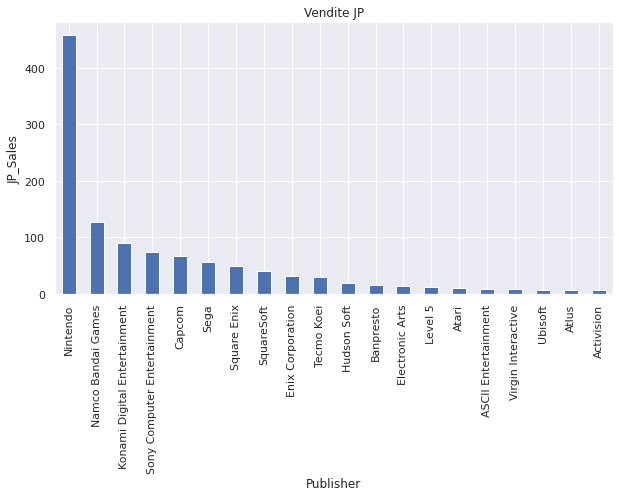

In [ ]:
tempPlot = publisherGroup.sort_values(by=['JP_Sales'], ascending=False).head(20)
tempPlot['JP_Sales'].plot(kind='bar', ylabel='JP_Sales', figsize=(10, 5), title='Vendite JP')

Anche per i publisher il Giappone si contina a distinguere

**Other_Sales**

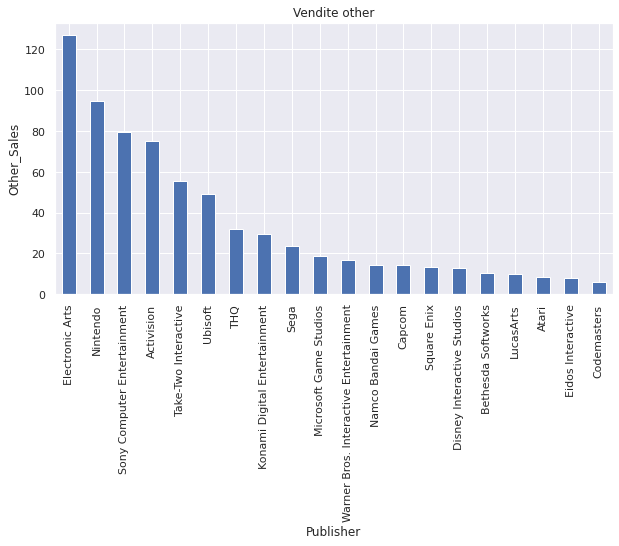

In [ ]:
tempPlot = publisherGroup.sort_values(by=['Other_Sales'], ascending=False).head(20)
tempPlot['Other_Sales'].plot(kind='bar', ylabel='Other_Sales', figsize=(10, 5), title='Vendite other')

Tranne per Other_Sales possiamo osservare come Nintendo abbia il dominio incontrastato sul mercato dando un notevo distacco anche solo alla seconda posizione

#Conclusioni

##Come avete ragionato (quali domande vi siete posti?)

Dopo un'attenta osservazione e studio delle feature ho deciso di modificare alcuni dati e predisporre il dataset per meglio manipolarli facendo dei cambi ti tipo e unità di misura. 

In seguito ho constatato di avere molti dati mancanti, questo mi ha portato a ragionare, come visto a lezione, se eliminare i dati o sostituirli con la media. In modo particolare nel caso del voto sia della critica che del pubblico.

Dopo aver notando una forte correlazione tra vedite in NA e vendite in EU mi sono chiesto se la media delle vendite in NA fosse uguale a quella in EU. Dopo aver ottenuto come risultato che la media delle vendite in NA e' maggiore rispetto a quella in EU ho implementato un modello di regressione lineare per stimare le vendite in EU a partire dalle vendite in NA.

In seguito all'analisi del voto delle critica e del pubblico in relazione alle vendite mi sono chiesto se ci fosse un qualche collegamento tra vendite di giochi e voto critica/pubblico, implementando un modello di regressione lineare per stimare il Global_Sales a partire dal Critic_Score. 
Il caso del voto della critica e' particolarmente interessante perche' ancora prima di avere i dati di vendite (dando la possibilita' ai critici videoludici di ricevere in anticipo il prodotto) permetterebbe di andare a fare delle predizioni sulle vendite.

Successivamente ho cercato di ottennere piu' informazioni possibili dal dataset raggruppando per alcune caratteristiche e andando a vedere a seconda dei casi come si comportavano le vendite e/o i voti. 
Sulle vendite ho prestato particolare attenzione nell'andare a guardare le varie differenze per zone di vendite così da poter comparare i mercati messi a disposizione dal dataset.
Seguono le domande su quest'ultima parte:
- Come si comportano i giochi prodotti e venduti per anno?
- Come si comportano i generi di videogiochi e le vendite?
- Come si comportano i generi di videogiochi e i voti?
- Come si comportano le piattaforme e le vendite?
- Come si comportano i publishere e le vendite?

##Quali sono le difficoltà che avete incontrato?
Molti dati mancanti e alcuni in grandi quantita' tra cui:
- Critic_Score, Critic_Count, User_Score, User_Coun, Developer, Rating
- Name, Platform, Year_of_Release, Genre                 
- anni 2018 e 2019 e 1 solo dato per 2020 (che per fare delle stime e' quasi come non averne)
 
Farsi delle domande la cui risposta poteva essera data dagli strumenti in nostro possesso.


##Quali sono i principali risultati che avete ottenuto?

I principali risultati ottenuti sono stati:

Verificare varie ipotesi tramite il T-test tra cui:
1. la media delle vendite in GS_real e' uguale a quella in Global_Sales
2. la media delle vendite in NA e' maggiore rispetto a quella in EU

Implemtare due modelli di regressione lineare per:
1. stimare le vendite in EU a partire dalle vendite in NA.
2. stimare il Global_Sales a partire dal Critic_Score.

Studiare le vendite nei vari paesi/stati ragruppando per svariate features ottenendo tramite visualizzazione numerica e grafica gli andamenti dei mercati e in particolare scoprendo come il Giappone si distingua da tutte le altre zone prese in esame. 



